In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import torch
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [3]:
df = pd.read_csv("../data/processed/processed_reviews.csv")

In [4]:
df.head()

,rating,review_length_text,review_length_title,polarity_text,polarity_title,subjectivity_text,subjectivity_title,lemmatized_text,lemmatized_title,day_of_week,month,year
0,1,408,2,0.018448,-1.0,0.512241,1.0,"['often', 'last', 'first', 'purchase', 'luggag...","['bad', 'airline']",Wednesday,11,2024
1,1,157,4,-0.060897,-1.0,0.592949,1.0,"['regard', 'booking', 'accommodation', 'regard...","['terrible', 'experience', 'airfrance']",Wednesday,11,2024
2,1,259,11,-0.094163,-0.6,0.488287,0.7,"['sky', 'sky', 'staff', 'amount', 'without', '...","['extremely', 'disappointing', 'experience', '...",Tuesday,11,2024
3,1,274,1,-0.109373,-1.0,0.494012,1.0,"['I', 've', 'always', 'shock', 'first', 'check...",['horrible'],Monday,11,2024
4,1,311,7,-0.126476,-1.0,0.485192,1.0,"['family', 'ruin', 'arrive', 'check', 'counter...","['bad', 'flight', 'experience', 'I', 've', 'ev...",Monday,11,2024


In [5]:
vader_analyzer = SentimentIntensityAnalyzer()


def get_vader_sentiment(text):
    if isinstance(text, str):
        scores = vader_analyzer.polarity_scores(text)
        return scores["compound"]


df["vader_sentiment"] = df["lemmatized_text"].apply(get_vader_sentiment)


In [6]:
df["vader_label"] = df["vader_sentiment"].apply(
    lambda x: "positive" if x > 0.05 else ("negative" if x < -0.05 else "neutral")
)

In [7]:
df[["lemmatized_text", "vader_sentiment", "vader_label"]].head()

,lemmatized_text,vader_sentiment,vader_label
0,"['often', 'last', 'first', 'purchase', 'luggag...",0.4019,positive
1,"['regard', 'booking', 'accommodation', 'regard...",-0.7906,negative
2,"['sky', 'sky', 'staff', 'amount', 'without', '...",-0.5332,negative
3,"['I', 've', 'always', 'shock', 'first', 'check...",-0.7003,negative
4,"['family', 'ruin', 'arrive', 'check', 'counter...",-0.8225,negative


In [8]:
# Convert text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df["lemmatized_text"].astype(str))
y = df["rating"].apply(
    lambda x: 1 if x > 3 else 0
)  # Binary sentiment: 1 (positive), 0 (negative)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = logistic_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


              precision    recall  f1-score   support

           0       0.74      0.80      0.77       260
           1       0.77      0.72      0.74       252

    accuracy                           0.76       512
   macro avg       0.76      0.76      0.76       512
weighted avg       0.76      0.76      0.76       512

Accuracy: 0.7578


In [ ]:
# Load pre-trained BERT sentiment classifier
bert_sentiment = pipeline("sentiment-analysis")


def get_bert_sentiment(text):
    if isinstance(text, str):
        # Truncate text if it's too long for BERT
        text = text[:500]  # Keeping it within a safe limit
        result = bert_sentiment(text)[0]  # Get sentiment prediction
        return result["label"], result["score"]
    return "neutral", 0  # Default for missing values


# Apply BERT sentiment analysis
df["bert_label"], df["bert_score"] = zip(
    *df["lemmatized_text"].apply(get_bert_sentiment)
)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Display results
df[["lemmatized_text", "bert_label", "bert_score"]].head()

,lemmatized_text,bert_label,bert_score
0,"['often', 'last', 'first', 'purchase', 'luggag...",NEGATIVE,0.941291
1,"['regard', 'booking', 'accommodation', 'regard...",NEGATIVE,0.996503
2,"['sky', 'sky', 'staff', 'amount', 'without', '...",NEGATIVE,0.997810
3,"['I', 've', 'always', 'shock', 'first', 'check...",NEGATIVE,0.985184
4,"['family', 'ruin', 'arrive', 'check', 'counter...",NEGATIVE,0.999053


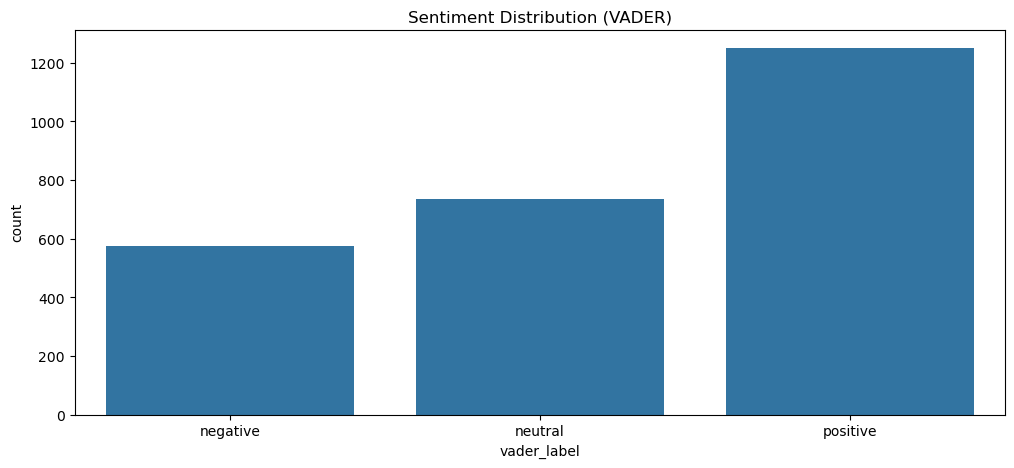

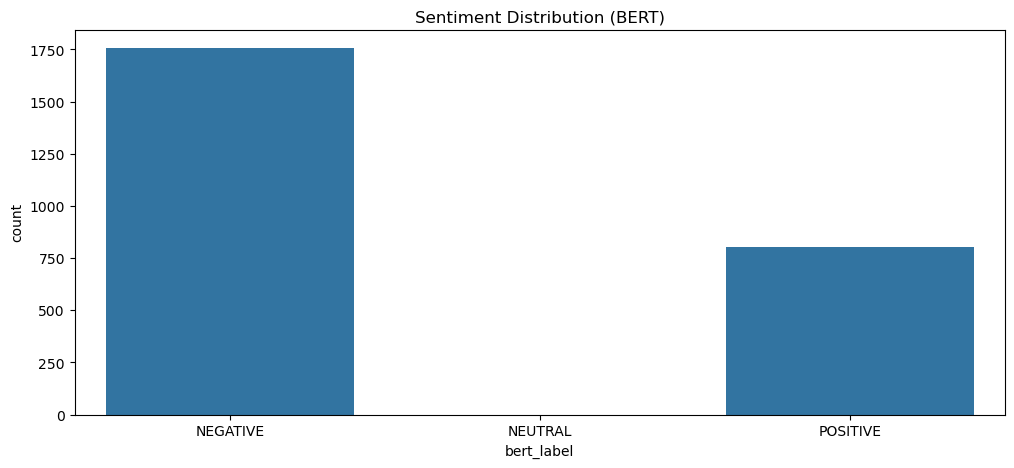

In [ ]:
# Plot sentiment distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x="vader_label", order=["negative", "neutral", "positive"])
plt.title("Sentiment Distribution (VADER)")
plt.show()

plt.figure(figsize=(12, 5))
sns.countplot(data=df, x="bert_label", order=["NEGATIVE", "NEUTRAL", "POSITIVE"])
plt.title("Sentiment Distribution (BERT)")
plt.show()


In [ ]:
# Save processed data with sentiment labels
df.to_csv("../data/processed/sentiment_analysis_results.csv", index=False)
print("Sentiment analysis results saved!")


Sentiment analysis results saved!


In [ ]:
# Show most positive and negative reviews
top_positive = df.nlargest(5, "bert_score")[
    ["lemmatized_text", "bert_label", "bert_score"]
]
top_negative = df.nsmallest(5, "bert_score")[
    ["lemmatized_text", "bert_label", "bert_score"]
]

print("Top 5 Positive Reviews:")
display(top_positive)
print("\nTop 5 Negative Reviews:")
display(top_negative)

Top 5 Positive Reviews:


,lemmatized_text,bert_label,bert_score
904,"['pleasantly', 'surprise', 'complimentary']",POSITIVE,0.999880
759,"['drink', 'delicious']",POSITIVE,0.999867
980,"['roomy', 'food', 'delicious']",POSITIVE,0.999867
1311,"['pleasantly', 'surprised', 'staff', 'standard']",POSITIVE,0.999861
2205,"['pleasantly', 'surprised', 'recent', 'smooth'...",POSITIVE,0.999861



Top 5 Negative Reviews:


,lemmatized_text,bert_label,bert_score
1099,"['check', 'boarding', 'smooth', 'organize', 'b...",POSITIVE,0.500183
1748,"['sit', 'first', 'front', 'long', 'figure', 'a...",POSITIVE,0.502100
986,"['age', 'food', 'tray']",POSITIVE,0.502876
1371,"['purchase', 'cost', 'boarding', 'without', 's...",NEGATIVE,0.504095
689,"['tight', 'tall', 'sit', 'bus', 'less', 'leg',...",NEGATIVE,0.505292


In [ ]:
# Load the raw data (df_raw)
df_raw = pd.read_csv("../data/raw/airfrance_tripadvisor_reviews.csv")
df_raw_text = df_raw["text"]  # Raw text column

# Load the LDA cluster labels dataset
df_reviews_lda = pd.read_csv(
    "../data/processed/cluster_analysis/reviews_with_lda_clusters.csv"
)

# Load the NMF cluster labels dataset
df_reviews_nmf = pd.read_csv(
    "../data/processed/cluster_analysis/reviews_with_nmf_clusters.csv"
)

# Load the Word2Vec cluster labels dataset
df_reviews_word2vec = pd.read_csv(
    "../data/processed/cluster_analysis/reviews_with_word2vec_clusters.csv"
)

# Load the HDBSCAN cluster labels dataset
df_reviews_hdbscan = pd.read_csv(
    "../data/processed/cluster_analysis/reviews_with_hdbscan_clusters.csv"
)

# Load the BERTopic cluster labels dataset
df_reviews_bertopic = pd.read_csv(
    "../data/processed/cluster_analysis/reviews_with_bertopic_clusters.csv"
)

# Create the final df_all_clusters DataFrame (copy to avoid SettingWithCopyWarning)
df_all_clusters = df_reviews_lda[["lda_labels"]].copy()  # Start with LDA cluster labels

# Add cluster labels for all models
df_all_clusters["nmf_labels"] = df_reviews_nmf["nmf_labels"]  # Add NMF cluster labels
df_all_clusters["word2vec_labels"] = df_reviews_word2vec[
    "word2vec_labels"
]  # Add Word2Vec cluster labels
df_all_clusters["hdbscan_labels"] = df_reviews_hdbscan[
    "sbert_hdbscan_topic"
]  # Add HDBSCAN cluster labels
df_all_clusters["sbert_bertopic_labels"] = df_reviews_bertopic[
    "sbert_bertopic"
]  # Add BERTopic cluster labels

# Add the raw text to the final DataFrame
df_all_clusters["text"] = df_raw_text

# Add additional columns from df_reviews_lda (or any other dataset that contains them)
df_all_clusters["rating"] = df_reviews_lda["rating"]
df_all_clusters["review_length_text"] = df_reviews_lda["review_length_text"]
df_all_clusters["review_length_title"] = df_reviews_lda["review_length_title"]
df_all_clusters["polarity_text"] = df_reviews_lda["polarity_text"]
df_all_clusters["polarity_title"] = df_reviews_lda["polarity_title"]
df_all_clusters["subjectivity_text"] = df_reviews_lda["subjectivity_text"]
df_all_clusters["subjectivity_title"] = df_reviews_lda["subjectivity_title"]
df_all_clusters["lemmatized_text"] = df_reviews_lda["lemmatized_text"]
df_all_clusters["lemmatized_title"] = df_reviews_lda["lemmatized_title"]
df_all_clusters["day_of_week"] = df_reviews_lda["day_of_week"]
df_all_clusters["month"] = df_reviews_lda["month"]
df_all_clusters["year"] = df_reviews_lda["year"]


# Check the final combined DataFrame
df_all_clusters  # View the first few rows of the combined DataFrame


,lda_labels,nmf_labels,word2vec_labels,hdbscan_labels,sbert_bertopic_labels,text,rating,review_length_text,review_length_title,polarity_text,polarity_title,subjectivity_text,subjectivity_title,lemmatized_text,lemmatized_title,day_of_week,month,year
0,4,6,0,-1,-1,I travel a lot - and I travel often. Last week...,1,408,2,0.018448,-1.000000,0.512241,1.00,"['often', 'last', 'first', 'purchase', 'luggag...","['bad', 'airline']",Wednesday,11,2024
1,3,7,0,20,-1,"This review is regarding flight AF185, we book...",1,157,4,-0.060897,-1.000000,0.592949,1.00,"['regard', 'booking', 'accommodation', 'regard...","['terrible', 'experience', 'airfrance']",Wednesday,11,2024
2,3,7,4,-1,-1,I recently flew with Air France on flight #185...,1,259,11,-0.094163,-0.600000,0.488287,0.70,"['sky', 'sky', 'staff', 'amount', 'without', '...","['extremely', 'disappointing', 'experience', '...",Tuesday,11,2024
3,7,7,0,14,-1,Wow!!! What a horrible experience!! I've alway...,1,274,1,-0.109373,-1.000000,0.494012,1.00,"['I', 've', 'always', 'shock', 'first', 'check...",['horrible'],Monday,11,2024
4,3,7,4,2,-1,I spent a fantastic 10-day vacation in Hong Ko...,1,311,7,-0.126476,-1.000000,0.485192,1.00,"['family', 'ruin', 'arrive', 'check', 'counter...","['bad', 'flight', 'experience', 'I', 've', 'ev...",Monday,11,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,2,1,4,18,-1,Flight with Air France nothing exceptional. On...,3,22,4,0.291667,0.666667,0.650000,1.00,"['onboard', 'movie', 'okay', 'staff', 'booking...","['air', 'france', 'nothing', 'exceptional']",Friday,2,2016
2556,0,3,3,18,10,"Expensive ticket, a plane from Paris to Madrid...",2,34,2,-0.133929,-0.650000,0.585714,0.95,"['expensive', 'booking', 'staff', 'glass', 'wa...","['unpleasant', 'surprise']",Thursday,2,2016
2557,4,6,4,7,0,I travelled with Airfrance and had a very bad ...,3,150,9,-0.014402,0.000000,0.529124,0.00,"['luggage', 'report', 'suppose', 'obviously', ...","['damage', 'baggage', 'assistance', 'replaceme...",Thursday,2,2016
2558,7,7,0,-1,-1,"Besides the astonishing new First Class cabin,...",5,49,5,0.332001,0.000000,0.499080,0.00,"['first', 'far', 'onboard', 's', 'french', 'sp...","['air', 'france', 'spoil']",Thursday,2,2016


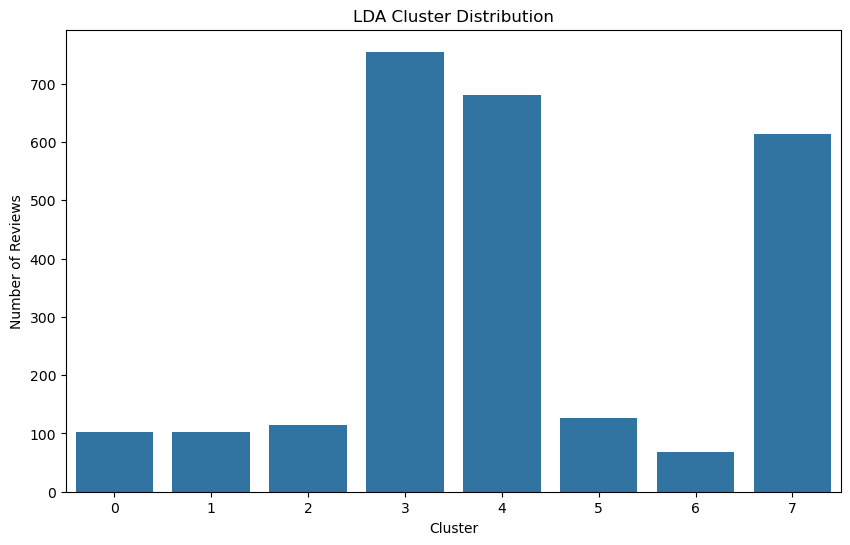

In [ ]:
from wordcloud import WordCloud
from collections import Counter

# Cluster Distributions for each model

# Plot distribution for LDA labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all_clusters, x="lda_labels")
plt.title("LDA Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()

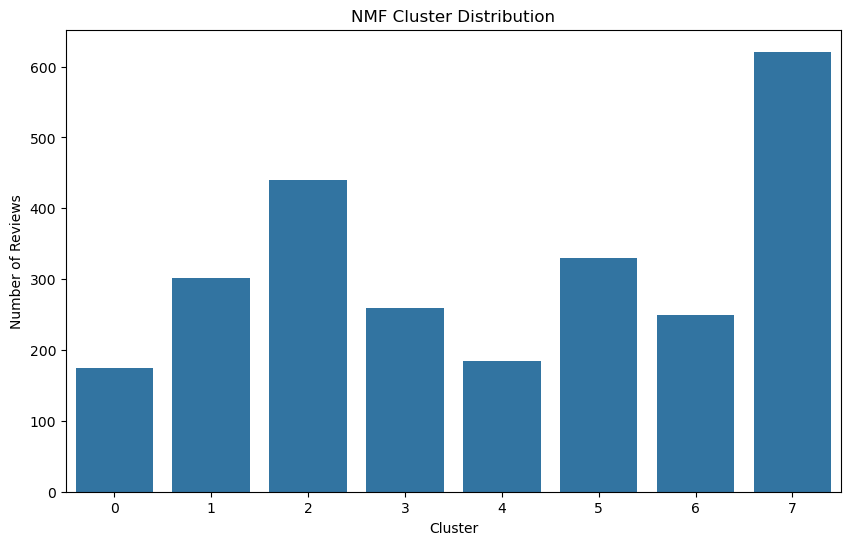

In [ ]:
# Plot distribution for NMF labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all_clusters, x="nmf_labels")
plt.title("NMF Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()

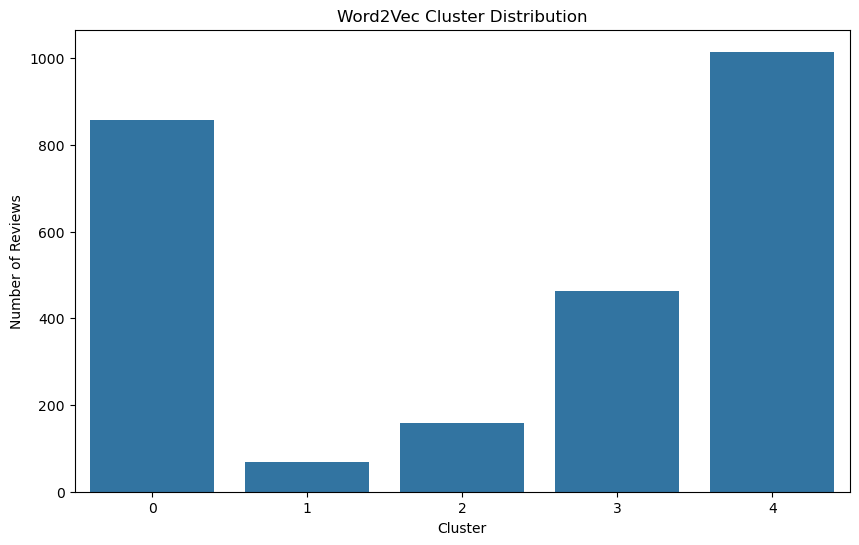

In [ ]:
# Plot distribution for Word2Vec labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all_clusters, x="word2vec_labels")
plt.title("Word2Vec Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()

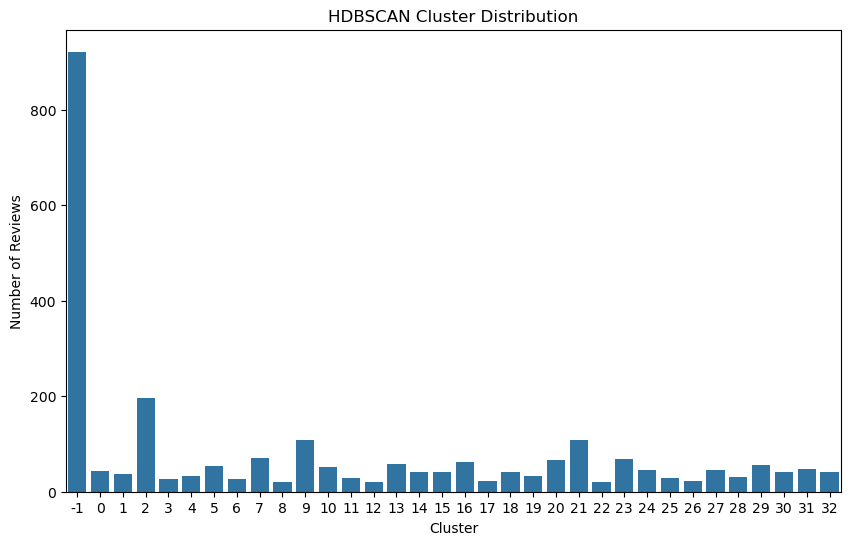

In [ ]:
# Plot distribution for HDBSCAN labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all_clusters, x="hdbscan_labels")
plt.title("HDBSCAN Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()

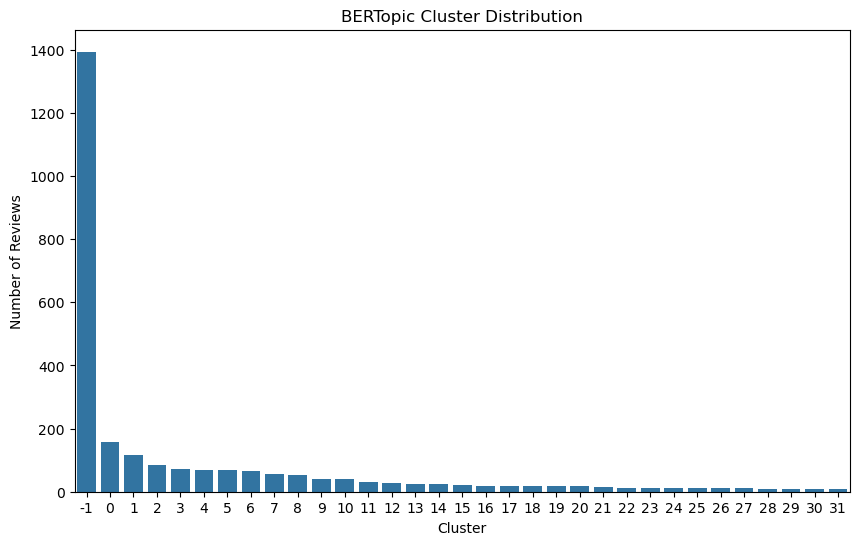

In [ ]:
# Plot distribution for BERTopic labels
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all_clusters, x="sbert_bertopic_labels")
plt.title("BERTopic Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()

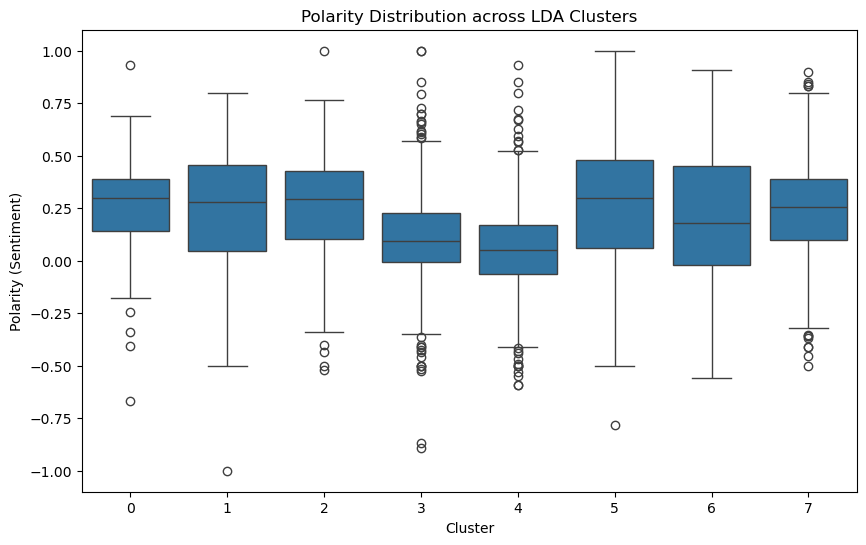

In [ ]:
# Boxplot for Polarity (Sentiment) across all clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="lda_labels", y="polarity_text", data=df_all_clusters)
plt.title("Polarity Distribution across LDA Clusters")
plt.xlabel("Cluster")
plt.ylabel("Polarity (Sentiment)")
plt.show()


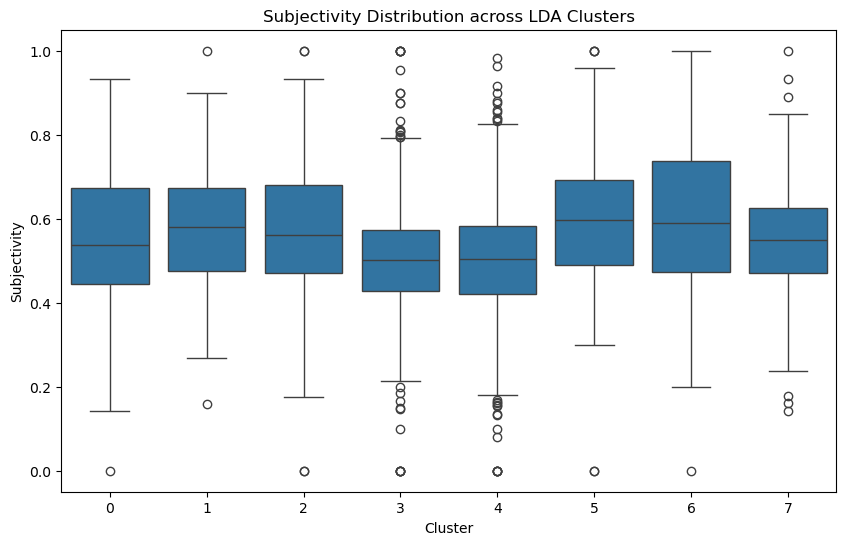

In [ ]:
# Boxplot for Subjectivity across all clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="lda_labels", y="subjectivity_text", data=df_all_clusters)
plt.title("Subjectivity Distribution across LDA Clusters")
plt.xlabel("Cluster")
plt.ylabel("Subjectivity")
plt.show()

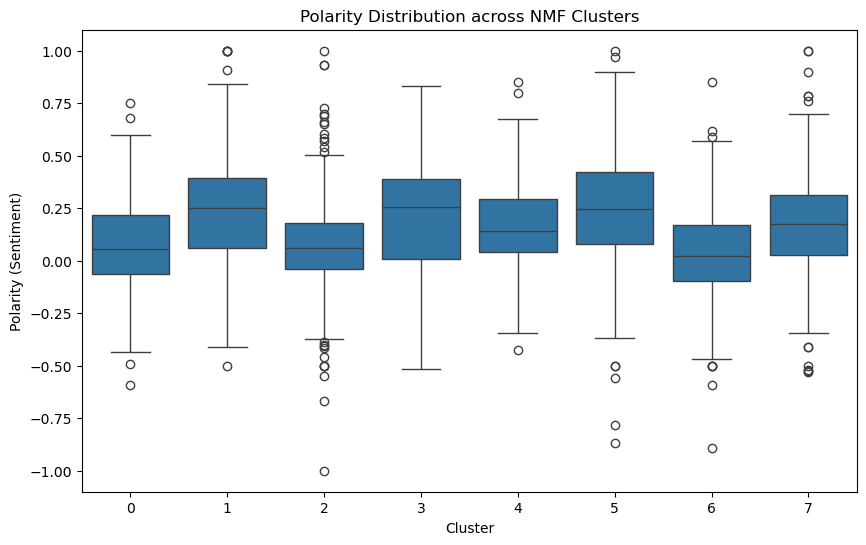

In [ ]:
# Boxplot for Polarity (Sentiment) across all clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="nmf_labels", y="polarity_text", data=df_all_clusters)
plt.title("Polarity Distribution across NMF Clusters")
plt.xlabel("Cluster")
plt.ylabel("Polarity (Sentiment)")
plt.show()

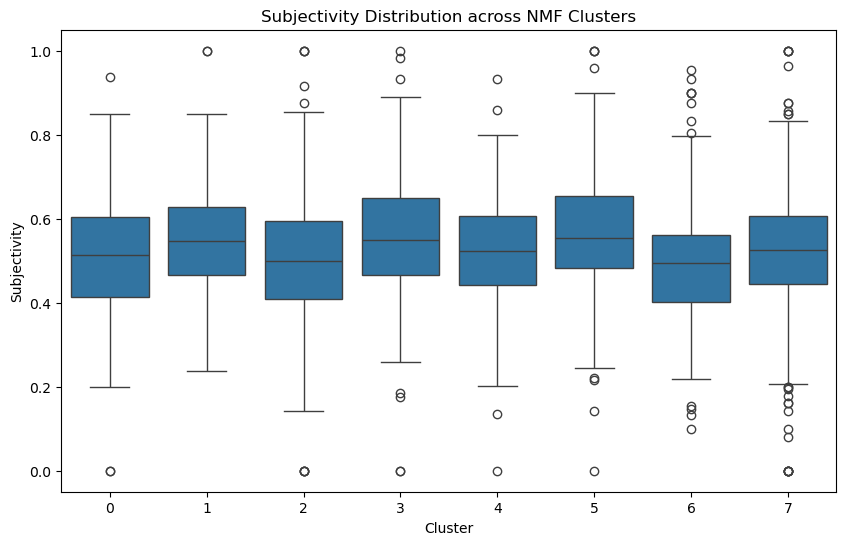

In [ ]:
# Boxplot for Subjectivity across all clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="nmf_labels", y="subjectivity_text", data=df_all_clusters)
plt.title("Subjectivity Distribution across NMF Clusters")
plt.xlabel("Cluster")
plt.ylabel("Subjectivity")
plt.show()

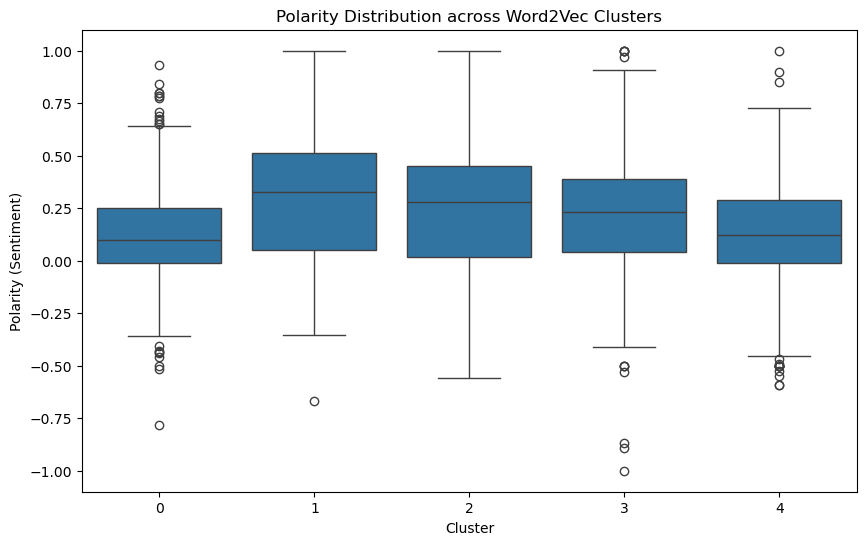

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="word2vec_labels", y="polarity_text", data=df_all_clusters)
plt.title("Polarity Distribution across Word2Vec Clusters")
plt.xlabel("Cluster")
plt.ylabel("Polarity (Sentiment)")
plt.show()

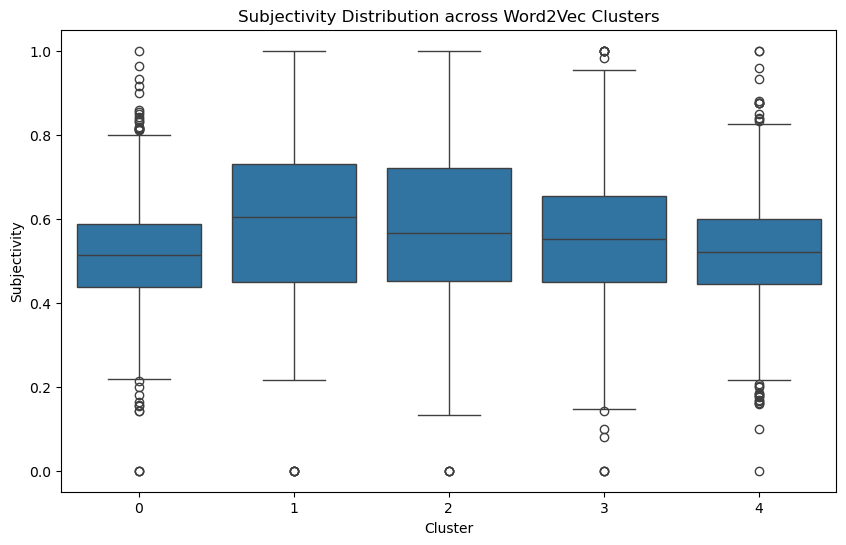

In [ ]:
# Boxplot for Subjectivity across all clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="word2vec_labels", y="subjectivity_text", data=df_all_clusters)
plt.title("Subjectivity Distribution across Word2Vec Clusters")
plt.xlabel("Cluster")
plt.ylabel("Subjectivity")
plt.show()

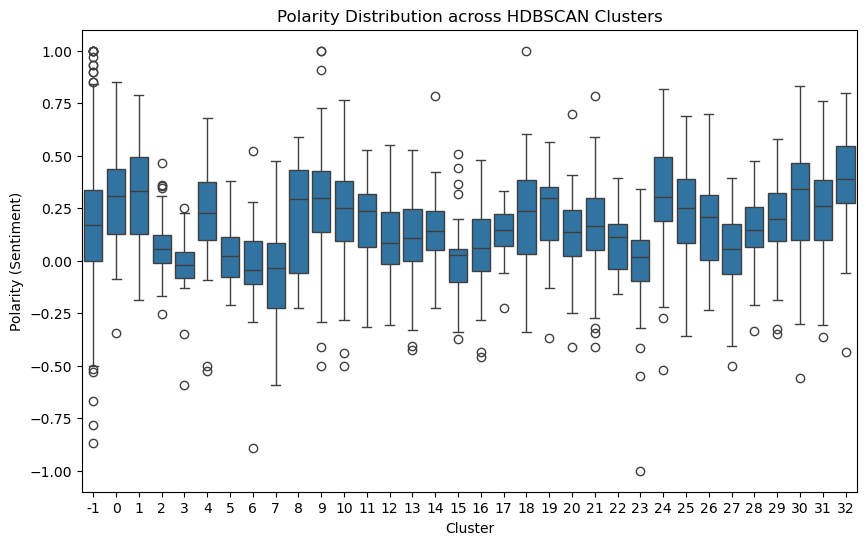

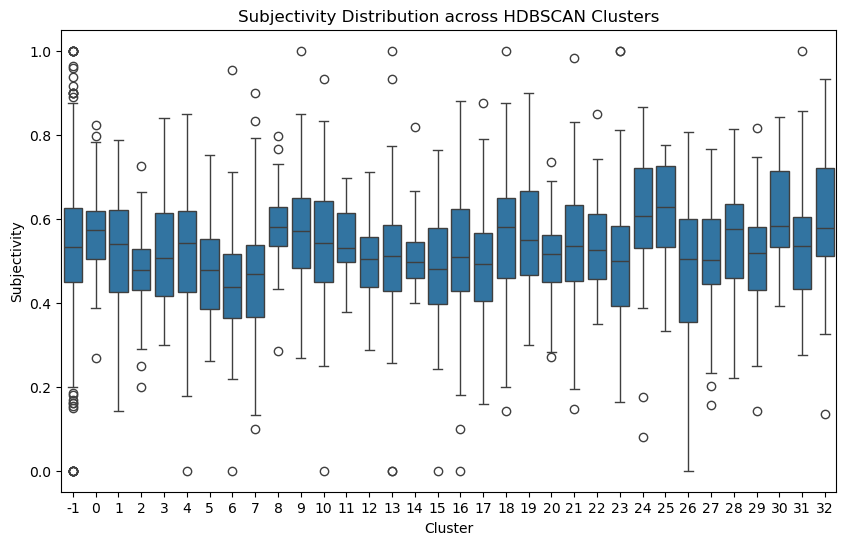

In [ ]:
# Boxplot for Polarity (Sentiment) across all clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="hdbscan_labels", y="polarity_text", data=df_all_clusters)
plt.title("Polarity Distribution across HDBSCAN Clusters")
plt.xlabel("Cluster")
plt.ylabel("Polarity (Sentiment)")
plt.show()

# Boxplot for Subjectivity across all clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="hdbscan_labels", y="subjectivity_text", data=df_all_clusters)
plt.title("Subjectivity Distribution across HDBSCAN Clusters")
plt.xlabel("Cluster")
plt.ylabel("Subjectivity")
plt.show()

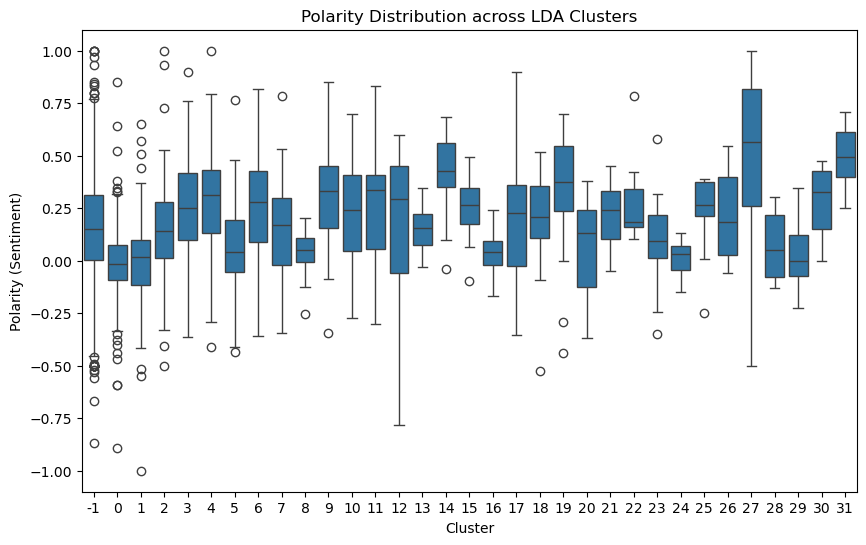

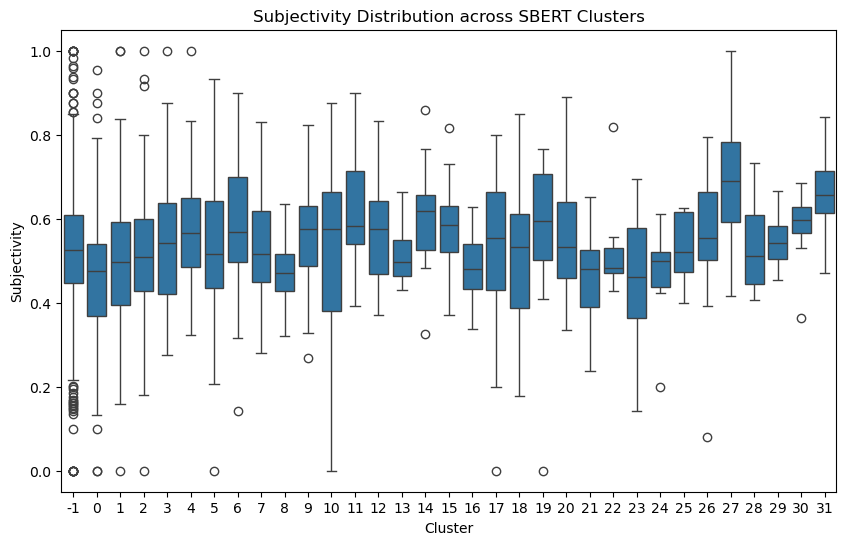

In [ ]:
# Boxplot for Polarity (Sentiment) across all clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="sbert_bertopic_labels", y="polarity_text", data=df_all_clusters)
plt.title("Polarity Distribution across LDA Clusters")
plt.xlabel("Cluster")
plt.ylabel("Polarity (Sentiment)")
plt.show()

# Boxplot for Subjectivity across all clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x="sbert_bertopic_labels", y="subjectivity_text", data=df_all_clusters)
plt.title("Subjectivity Distribution across SBERT Clusters")
plt.xlabel("Cluster")
plt.ylabel("Subjectivity")
plt.show()

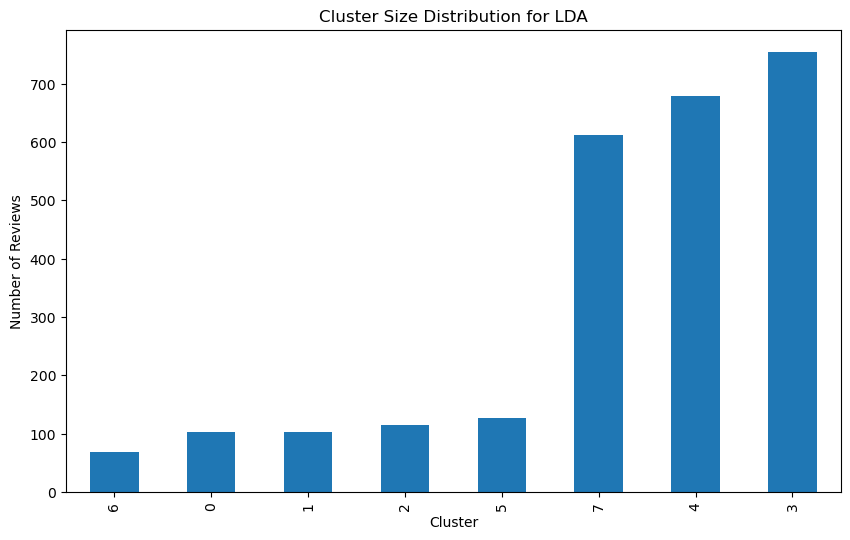

In [ ]:
# Cluster Size Analysis
cluster_sizes = df_all_clusters[
    "lda_labels"
].value_counts()  # Cluster size by LDA labels
cluster_sizes.sort_values().plot(kind="bar", figsize=(10, 6))
plt.title("Cluster Size Distribution for LDA")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()


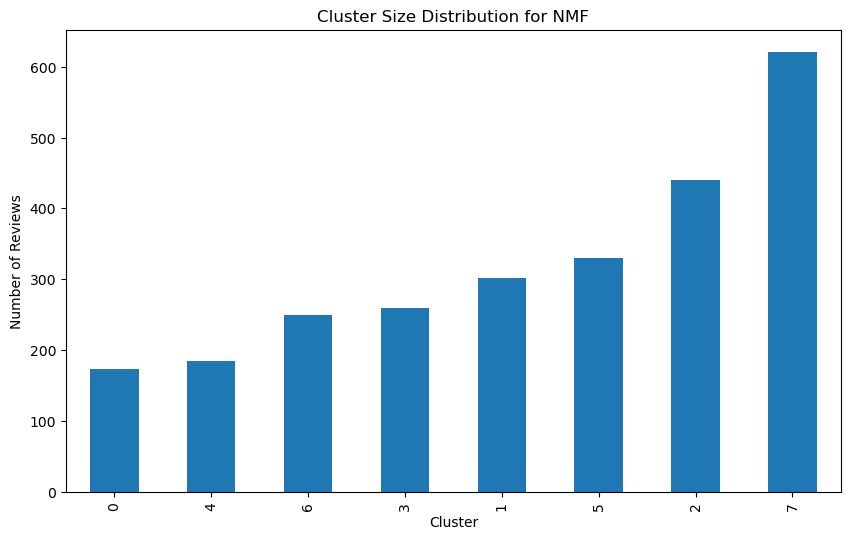

In [ ]:
# Cluster Size Analysis
cluster_sizes = df_all_clusters[
    "nmf_labels"
].value_counts()  # Cluster size by LDA labels
cluster_sizes.sort_values().plot(kind="bar", figsize=(10, 6))
plt.title("Cluster Size Distribution for NMF")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()


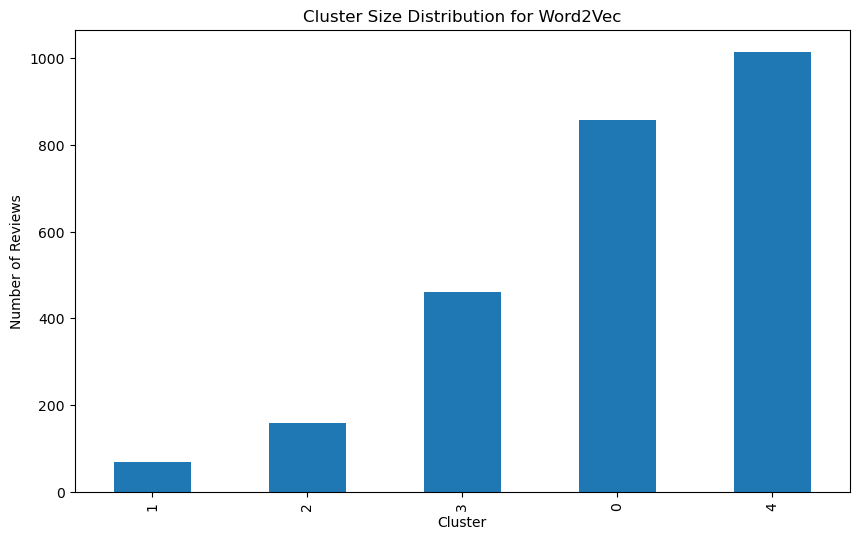

In [ ]:
# Cluster Size Analysis
cluster_sizes = df_all_clusters[
    "word2vec_labels"
].value_counts()  # Cluster size by LDA labels
cluster_sizes.sort_values().plot(kind="bar", figsize=(10, 6))
plt.title("Cluster Size Distribution for Word2Vec")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()

# Repeat for NMF, Word2Vec, HDBSCAN, and BERTopic


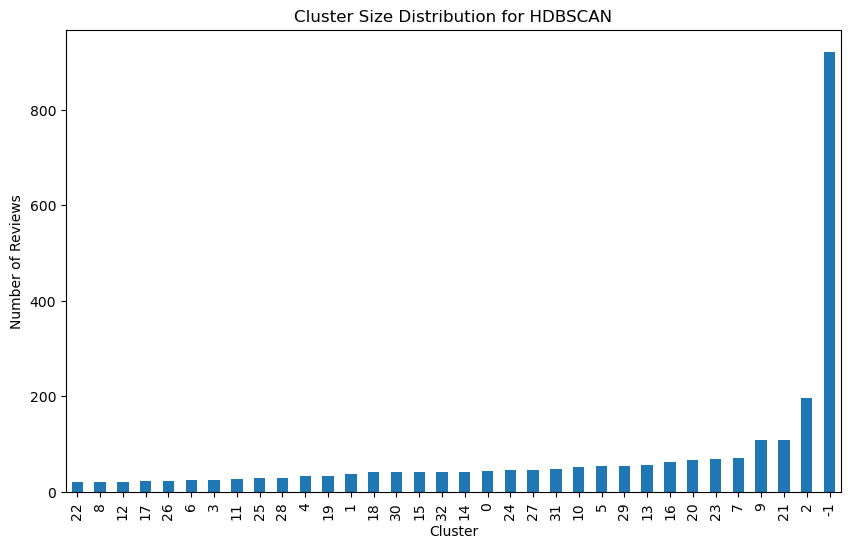

In [ ]:
# Cluster Size Analysis
cluster_sizes = df_all_clusters[
    "hdbscan_labels"
].value_counts()  # Cluster size by LDA labels
cluster_sizes.sort_values().plot(kind="bar", figsize=(10, 6))
plt.title("Cluster Size Distribution for HDBSCAN")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()

# Repeat for NMF, Word2Vec, HDBSCAN, and BERTopic


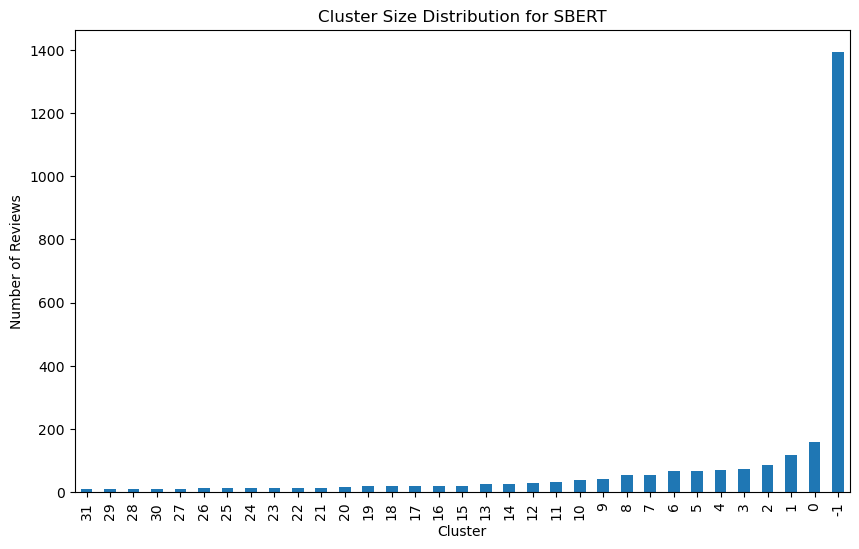

In [ ]:
# Cluster Size Analysis
cluster_sizes = df_all_clusters[
    "sbert_bertopic_labels"
].value_counts()  # Cluster size by LDA labels
cluster_sizes.sort_values().plot(kind="bar", figsize=(10, 6))
plt.title("Cluster Size Distribution for SBERT")
plt.xlabel("Cluster")
plt.ylabel("Number of Reviews")
plt.show()

# Repeat for NMF, Word2Vec, HDBSCAN, and BERTopic


In [ ]:
# Calculate overlap between clusters
overlap = df_all_clusters.groupby("lda_labels")["text"].apply(
    lambda x: len(x) / len(df_all_clusters)
)  # Proportion of each cluster
print("Cluster Overlap: ", overlap)


Cluster Overlap:  lda_labels
0    0.039844
1    0.039844
2    0.044531
3    0.294922
4    0.265625
5    0.049219
6    0.026562
7    0.239453
Name: text, dtype: float64


In [ ]:
# Calculate overlap between clusters
overlap = df_all_clusters.groupby("nmf_labels")["text"].apply(
    lambda x: len(x) / len(df_all_clusters)
)  # Proportion of each cluster
print("Cluster Overlap: ", overlap)


Cluster Overlap:  nmf_labels
0    0.067969
1    0.117969
2    0.171875
3    0.101172
4    0.071875
5    0.128906
6    0.097656
7    0.242578
Name: text, dtype: float64


In [ ]:
# Calculate overlap between clusters (LDA as an example)
overlap = df_all_clusters.groupby("hdbscan_labels")["text"].apply(
    lambda x: len(x) / len(df_all_clusters)
)  # Proportion of each cluster
print("Cluster Overlap: ", overlap)


Cluster Overlap:  hdbscan_labels
-1     0.359766
 0     0.017188
 1     0.014453
 2     0.076953
 3     0.010156
 4     0.012891
 5     0.021094
 6     0.010156
 7     0.027734
 8     0.008203
 9     0.042188
 10    0.020313
 11    0.010937
 12    0.008203
 13    0.022266
 14    0.016406
 15    0.016016
 16    0.024219
 17    0.008594
 18    0.016016
 19    0.012891
 20    0.025781
 21    0.042578
 22    0.008203
 23    0.026562
 24    0.017969
 25    0.011328
 26    0.008594
 27    0.017969
 28    0.011719
 29    0.021484
 30    0.016016
 31    0.018750
 32    0.016406
Name: text, dtype: float64


In [ ]:
# Calculate overlap between clusters (LDA as an example)
overlap = df_all_clusters.groupby("word2vec_labels")["text"].apply(
    lambda x: len(x) / len(df_all_clusters)
)  # Proportion of each cluster
print("Cluster Overlap: ", overlap)


Cluster Overlap:  word2vec_labels
0    0.334766
1    0.026562
2    0.061719
3    0.180469
4    0.396484
Name: text, dtype: float64


In [ ]:
# Calculate overlap between clusters (LDA as an example)
overlap = df_all_clusters.groupby("sbert_bertopic_labels")["text"].apply(
    lambda x: len(x) / len(df_all_clusters)
)  # Proportion of each cluster
print("Cluster Overlap: ", overlap)


Cluster Overlap:  sbert_bertopic_labels
-1     0.544531
 0     0.062109
 1     0.045703
 2     0.033594
 3     0.028125
 4     0.026953
 5     0.026562
 6     0.025781
 7     0.021484
 8     0.021094
 9     0.015625
 10    0.015234
 11    0.012109
 12    0.010547
 13    0.009375
 14    0.009375
 15    0.007812
 16    0.007031
 17    0.007031
 18    0.007031
 19    0.007031
 20    0.006641
 21    0.005469
 22    0.005078
 23    0.004687
 24    0.004687
 25    0.004687
 26    0.004687
 27    0.004297
 28    0.003906
 29    0.003906
 30    0.003906
 31    0.003906
Name: text, dtype: float64


In [ ]:
import pickle
with open("../data/interim/sbert_vectorized.pkl", "rb") as f:
    sbert_embeddings = pickle.load(f)

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances


# Function to calculate intra-cluster cohesion (average pairwise distance within each cluster)
def intra_cluster_distance(embeddings, labels):
    unique_labels = np.unique(labels)
    intra_cluster_dists = []
    for label in unique_labels:
        if (
            label == -1
        ):  # Skip noise points for DBSCAN and HDBSCAN (-1 is usually noise)
            continue
        cluster_points = embeddings[labels == label]
        # Calculate pairwise distances within the cluster
        dist_matrix = cdist(cluster_points, cluster_points, metric="euclidean")
        # Take the mean of the pairwise distances as the cohesion score
        intra_cluster_dists.append(np.mean(dist_matrix))
    return np.mean(intra_cluster_dists)


# Function to calculate clustering metrics for all models
def calculate_clustering_metrics(embeddings, labels, model_name):
    print(f"Evaluating {model_name} Clusters")

    # Silhouette Score (higher is better)
    silhouette = silhouette_score(embeddings, labels)
    print(f"Silhouette Score for {model_name}: {silhouette}")

    # Davies-Bouldin Index (lower is better)
    davies_bouldin = davies_bouldin_score(embeddings, labels)
    print(f"Davies-Bouldin Index for {model_name}: {davies_bouldin}")

    # Intra-cluster Distance (Cohesion)
    cohesion = intra_cluster_distance(embeddings, labels)
    print(f"Intra-cluster Distance (Cohesion) for {model_name}: {cohesion}")

    print("-" * 50)


# HDBSCAN Model
calculate_clustering_metrics(
    sbert_embeddings, df_all_clusters["hdbscan_labels"], "HDBSCAN"
)

# LDA Model
calculate_clustering_metrics(sbert_embeddings, df_all_clusters["lda_labels"], "LDA")

# NMF Model
calculate_clustering_metrics(sbert_embeddings, df_all_clusters["nmf_labels"], "NMF")

# Word2Vec Model
calculate_clustering_metrics(
    sbert_embeddings, df_all_clusters["word2vec_labels"], "Word2Vec"
)

# BERTopic Model
calculate_clustering_metrics(
    sbert_embeddings, df_all_clusters["bertopic_labels"], "BERTopic"
)


In [ ]:
import umap
import matplotlib.pyplot as plt

# Apply UMAP for dimensionality reduction to 2D (UMAP is faster than t-SNE)
umap_reducer = umap.UMAP(
    n_components=2, random_state=42, n_neighbors=15, metric="cosine"
)
sbert_reduced_2d = umap_reducer.fit_transform(sbert_embeddings)

# Visualize clusters for LDA
plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_2d[:, 0],
    sbert_reduced_2d[:, 1],
    c=df_all_clusters["lda_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D UMAP Visualization of SBERT Embeddings with LDA Clusters")
plt.colorbar()
plt.show()

# Repeat for NMF, Word2Vec, HDBSCAN, and BERTopic
plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_2d[:, 0],
    sbert_reduced_2d[:, 1],
    c=df_all_clusters["nmf_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D UMAP Visualization of SBERT Embeddings with NMF Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_2d[:, 0],
    sbert_reduced_2d[:, 1],
    c=df_all_clusters["word2vec_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D UMAP Visualization of SBERT Embeddings with Word2Vec Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_2d[:, 0],
    sbert_reduced_2d[:, 1],
    c=df_all_clusters["hdbscan_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D UMAP Visualization of SBERT Embeddings with HDBSCAN Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_2d[:, 0],
    sbert_reduced_2d[:, 1],
    c=df_all_clusters["bertopic_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D UMAP Visualization of SBERT Embeddings with BERTopic Clusters")
plt.colorbar()
plt.show()


In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction to 2D (Good for visualization)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
sbert_reduced_tsne = tsne.fit_transform(sbert_embeddings)

# Visualize clusters for LDA
plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_tsne[:, 0],
    sbert_reduced_tsne[:, 1],
    c=df_all_clusters["lda_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D t-SNE Visualization of SBERT Embeddings with LDA Clusters")
plt.colorbar()
plt.show()

# Repeat for NMF, Word2Vec, HDBSCAN, and BERTopic
plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_tsne[:, 0],
    sbert_reduced_tsne[:, 1],
    c=df_all_clusters["nmf_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D t-SNE Visualization of SBERT Embeddings with NMF Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_tsne[:, 0],
    sbert_reduced_tsne[:, 1],
    c=df_all_clusters["word2vec_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D t-SNE Visualization of SBERT Embeddings with Word2Vec Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_tsne[:, 0],
    sbert_reduced_tsne[:, 1],
    c=df_all_clusters["hdbscan_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D t-SNE Visualization of SBERT Embeddings with HDBSCAN Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    sbert_reduced_tsne[:, 0],
    sbert_reduced_tsne[:, 1],
    c=df_all_clusters["bertopic_labels"],
    cmap="Spectral",
    s=5,
)
plt.title("2D t-SNE Visualization of SBERT Embeddings with BERTopic Clusters")
plt.colorbar()
plt.show()


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def plot_wordcloud(cluster_column, model_name):
    # Generate WordCloud for each cluster
    for cluster in df_all_clusters[cluster_column].unique():
        words = " ".join(
            df_all_clusters[df_all_clusters[cluster_column] == cluster][
                "lemmatized_text"
            ]
        ).lower()

        # Generate the WordCloud with custom settings
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            max_words=50,  # Adjust to limit the number of words displayed
            colormap="viridis",  # Adjust color scheme for better contrast
            max_font_size=100,  # Increase font size to make prominent words bigger   # Use stopwords to filter common words
        ).generate(words)

        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"WordCloud for {model_name} Cluster {cluster}")
        plt.axis("off")  # Hide axis for cleaner visualization
        plt.show()


NameError: name 'df_all_clusters' is not defined

In [ ]:
plot_wordcloud("nmf_labels", "NMF")


In [ ]:
plot_wordcloud("hdbscan_labels", "HDBSCAN")